# Histograms

### Code by Amelia Lach

In [1]:
from gerrychain import (GeographicPartition,
                        Graph, 
                        updaters,
                        Election
                        )
import numpy as np
import statistics
import matplotlib.pyplot as plt
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, Election
from gerrychain.updaters import cut_edges, Tally
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
import geopandas as gpd
import pandas as pd

### Setting Up File

In [2]:
gdf = gpd.read_file('./IN/IN.shp')

gdf = gdf.fillna(value={'ALL_TOT20': 0})
gdf = gdf.fillna(value={'VAP_TOT20': 0})
graph = Graph.from_geodataframe(gdf)

### Setting Up Relevant Variables

In [3]:
tot_pop = sum([graph.nodes()[v]['ALL_TOT20'] for v in graph.nodes()])
num_dist = 9 # Number of Congressional Districts in Indiana
ideal_pop = tot_pop/num_dist
pop_tolerance = 0.02

### Function for # of Republican Districts

In [4]:
def republican_wins(partition):
    republican_won = 0
    for district in partition.parts:
        democratic_votes = partition["dem votes"][district]
        republican_votes = partition["rep votes"][district]
        total_votes = democratic_votes + republican_votes
        if republican_votes / total_votes > 0.5:
            republican_won += 1
    return republican_won

### Setting Up Partition

In [5]:
initial_partition = Partition(
      graph, 
      assignment="CD",
      updaters={
          "cut_edges":cut_edges, 
          "population": Tally("ALL_TOT20", alias="population"),  
          "rep votes": Tally("PRES20R", alias = "rep votes"),
          "dem votes": Tally("PRES20D", alias = "dem votes"),
          "republican_won": republican_wins,
      }
)

### Setting Up Proposal

In [6]:
# Define proposal and constraints
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "ALL_TOT20", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                             
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              
                      node_repeats = 1 ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                      )

### Constraints

In [7]:
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, 
    pop_tolerance, 
    pop_key="population")

### Markov Chain

In [8]:
# Creating the Markov Chain
our_random_walk = MarkovChain(
    proposal = rw_proposal, 
    constraints = [population_constraint],
    accept = always_accept, # Accept every proposed plan that meets the population constraints
    initial_state = initial_partition, 
    total_steps = 8000) 

### Lists for storing data

In [9]:
cutedge_ensemble = []
republican_won_ensemble = []

### Running Markov Chain

In [13]:
# Running the Markov Chain
for part in our_random_walk:
    # Add cutedges to cutedges ensemble
    cutedge_ensemble.append(len(part["cut_edges"]))
    
    republican_won_ensemble.append(part["republican_won"])

### Histogram of Cut Edges

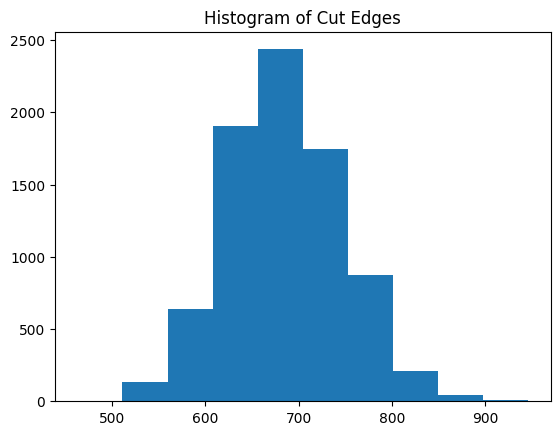

In [14]:
plt.figure()
plt.hist(cutedge_ensemble, align = 'left')
plt.title("Histogram of Cut Edges")
plt.show()
#plt.savefig('histogram_cut_edges.png')

### Histogram of Republican Districts

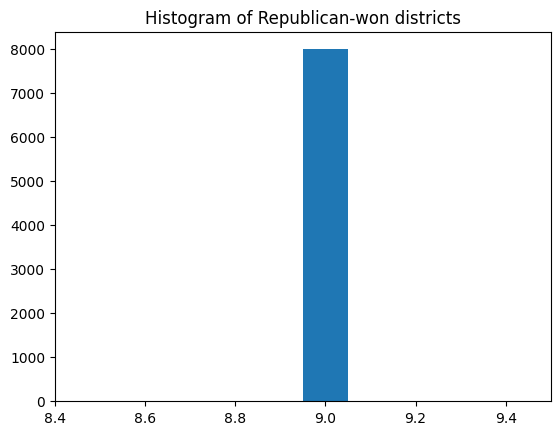

In [15]:
plt.figure()
plt.hist(republican_won_ensemble, align = 'left')
plt.title("Histogram of Republican-won districts")
plt.show()
#plt.savefig('histogram_democratic_won.png')